I have the clean data from the previous step that includes:

DATE: in datetime format <br>
PRCP: water equivalent (in) or precipitation (if all the snow was melted down to water) <br>
SNOW: new snow measured in inches <br>
SNWD: snow depth measured in inches <br>
TMAX: max temperature observed on that day <br>
TMIN: min temperature observed on that day <br>
TOBS: official observed tempterature observed on that day <br>
MONTH: month separated from Date to make groupby easier <br>
DAY: day separated from Date to make groupby easier <br>
PDO: pacific decadal oscillation; data given by the month but interpolated to the day <br>
AMO: atlantic decadal oscillation; data measure by the month but interpolated to the day <br>
SNOW7: 7-day snow total <br>
SNOW14: 14-day snow total <br>
SNOW30: 30-day snow total <br>
DEN: snow density <br>
MD: month-day; month and day of the data extract from DATE <br>



In [234]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import ppscore as pps

In [235]:
import pickle
path="C:\Springboard\Github\Capstone1_alta\intermediate_data"
os.chdir(path)

In [236]:
ALTA = pickle.load(open("alta_snow_eda.pkl", "rb"))
ALTA.head(10)

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO,SNOW7,SNOW14,SNOW30,DEN,MD
0,1944-11-21,0.00,0.0,20.0,52.0,9.0,20.0,11,21,-0.48,0.272,NaN,NaN,NaN,NaN,11-21
1,1944-11-22,0.00,0.0,19.0,48.0,19.0,29.0,11,22,-0.48,0.272,NaN,NaN,NaN,NaN,11-22
2,1944-11-23,0.00,0.0,19.0,56.0,24.0,40.0,11,23,-0.48,0.272,NaN,NaN,NaN,NaN,11-23
3,1944-11-24,0.82,6.0,25.0,52.0,14.0,16.0,11,24,-0.48,0.272,NaN,NaN,NaN,7.317073,11-24
4,1944-11-25,0.06,11.0,36.0,26.0,11.0,14.0,11,25,-0.48,0.272,NaN,NaN,NaN,NaN,11-25
5,1944-11-26,0.00,0.0,36.0,29.0,7.0,16.0,11,26,-0.48,0.272,NaN,NaN,NaN,NaN,11-26
6,1944-11-27,0.00,0.0,34.0,37.0,13.0,20.0,11,27,-0.48,0.272,17.0,NaN,NaN,NaN,11-27
7,1944-11-28,0.25,3.0,37.0,44.0,10.0,12.0,11,28,-0.48,0.272,20.0,NaN,NaN,NaN,11-28
8,1944-11-29,0.00,0.0,35.0,44.0,11.0,30.0,11,29,-0.48,0.272,20.0,NaN,NaN,NaN,11-29
9,1944-11-30,0.00,0.0,33.0,38.0,19.0,25.0,11,30,-0.48,0.272,20.0,NaN,NaN,NaN,11-30


In [237]:
ALTA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21809 entries, 0 to 21808
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    21809 non-null  datetime64[ns]
 1   PRCP    21809 non-null  float64       
 2   SNOW    21809 non-null  float64       
 3   SNWD    21809 non-null  float64       
 4   TMAX    21809 non-null  float64       
 5   TMIN    21809 non-null  float64       
 6   TOBS    21809 non-null  float64       
 7   MONTH   21809 non-null  object        
 8   DAY     21809 non-null  object        
 9   PDO     21808 non-null  float64       
 10  AMO     21808 non-null  float64       
 11  SNOW7   21803 non-null  float64       
 12  SNOW14  21796 non-null  float64       
 13  SNOW30  21780 non-null  float64       
 14  DEN     2084 non-null   float64       
 15  MD      21809 non-null  object        
dtypes: datetime64[ns](1), float64(12), object(3)
memory usage: 2.8+ MB


Let's fill those SNOW7, 14 and 30 so that we don't have NaN in times series.

In [238]:
ALTA['SNOW7'].fillna(value=0, inplace=True)
ALTA['SNOW14'].fillna(value=0, inplace=True)
ALTA['SNOW30'].fillna(value=0, inplace=True)

In [239]:
# import time series stuff
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

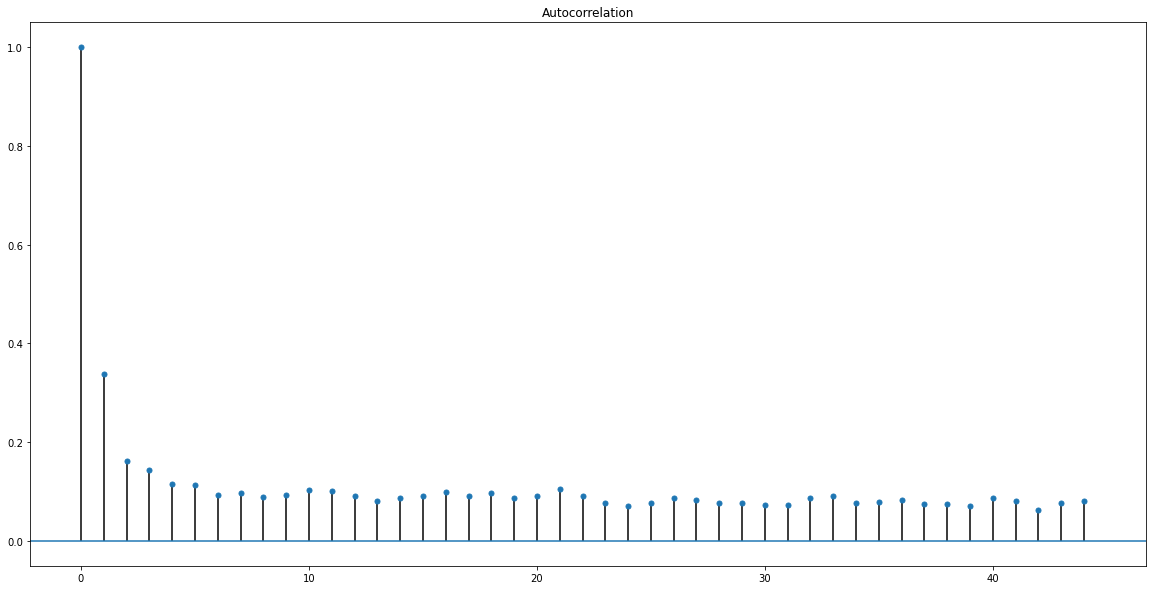

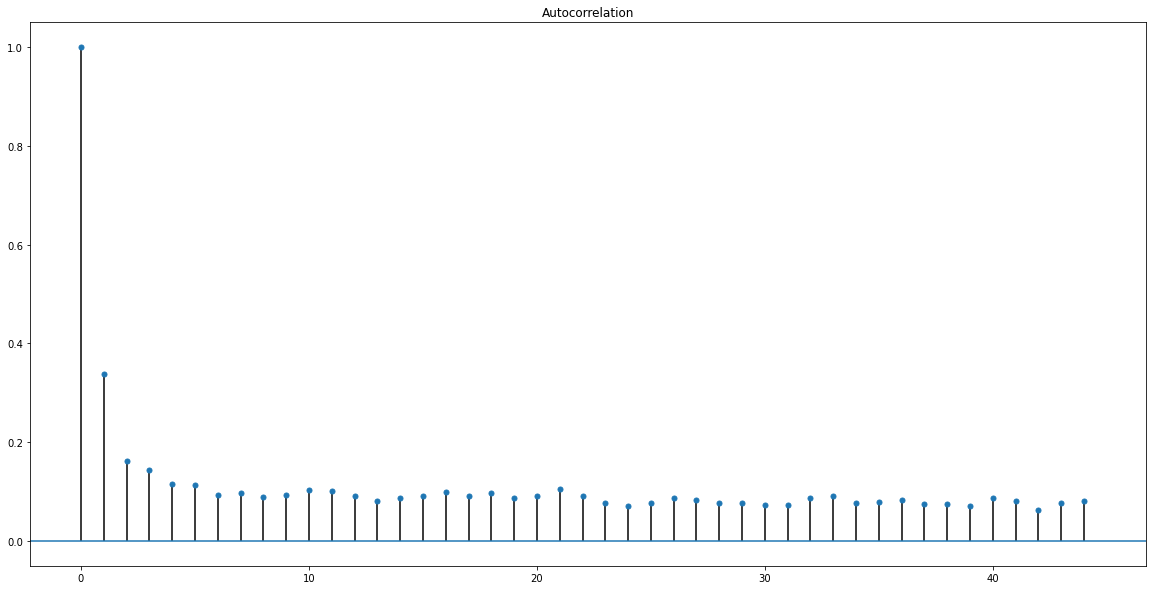

In [240]:
# looking at the standard ACF Plot
plot_acf(ALTA['SNOW'], alpha=1)

That's to be expected. The day's snowfall is closely correlated to the next day. We should also look at percent change and difference between snowfall days to see if there is any autocorrelation there.

In [241]:
diff_snow = ALTA['SNOW'].diff()
pc_snow = ALTA['SNOW'].pct_change()

In [242]:
diff_snow.head()

0    NaN
1    0.0
2    0.0
3    6.0
4    5.0
Name: SNOW, dtype: float64

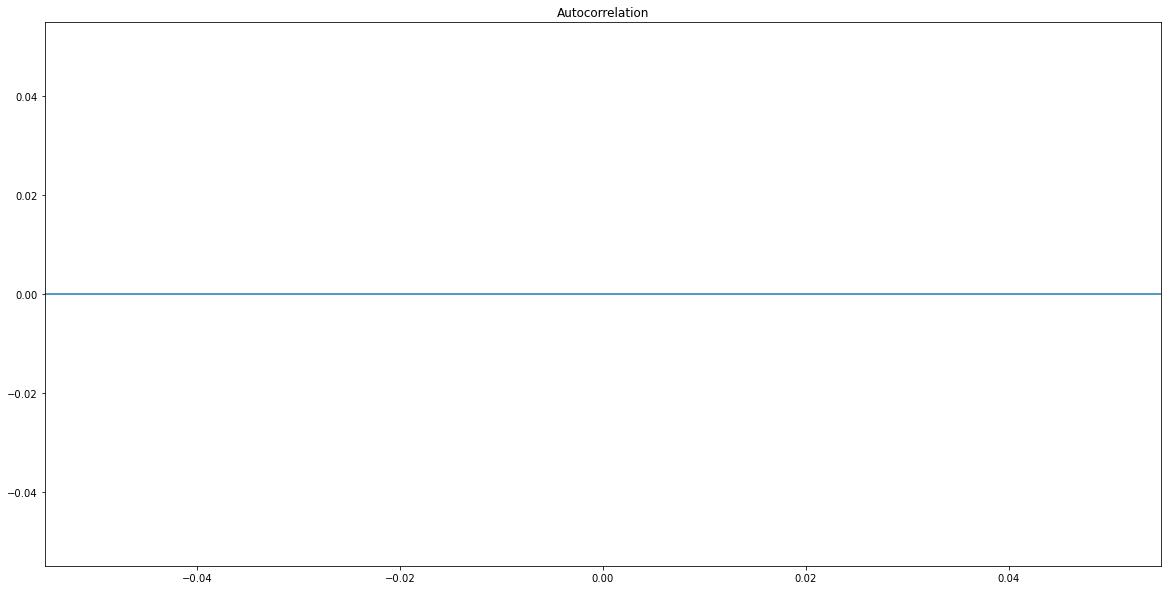

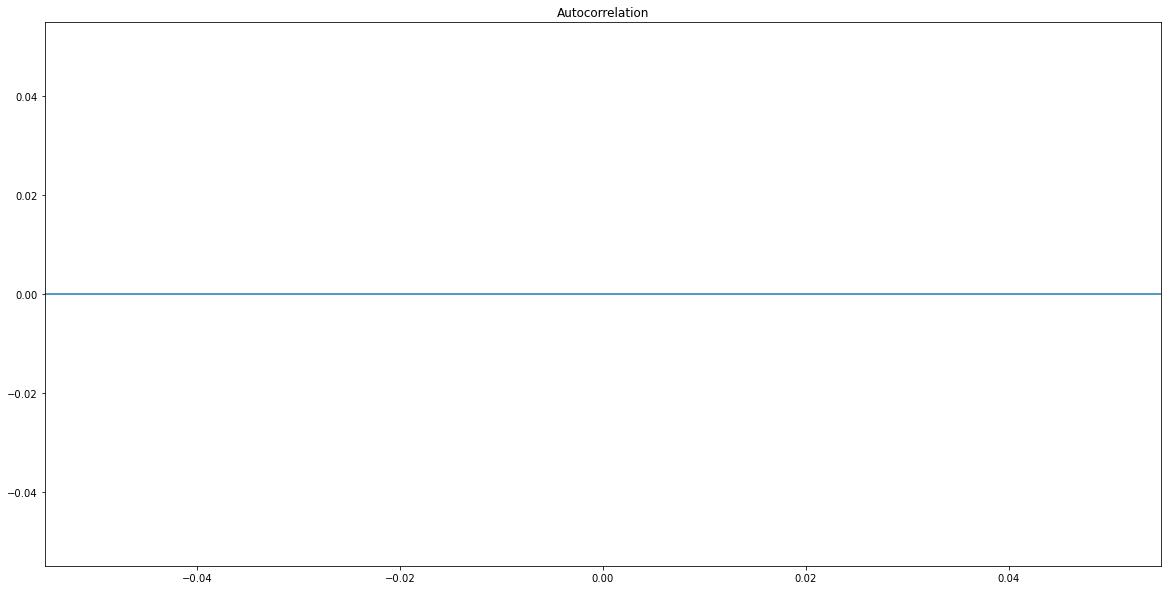

In [243]:
plot_acf(diff_snow, alpha=1)

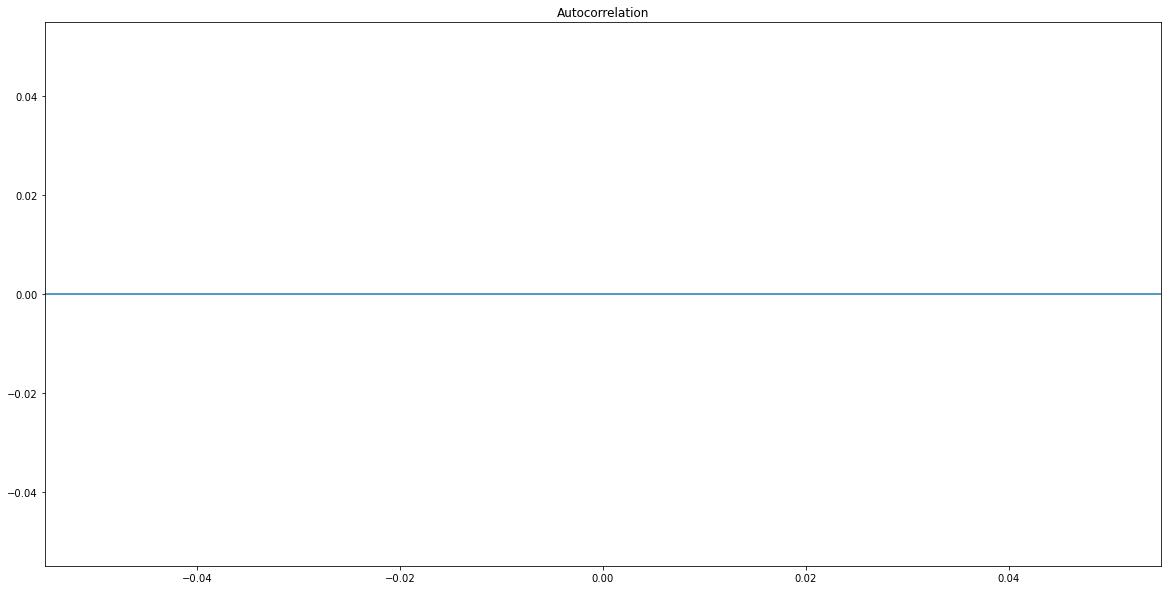

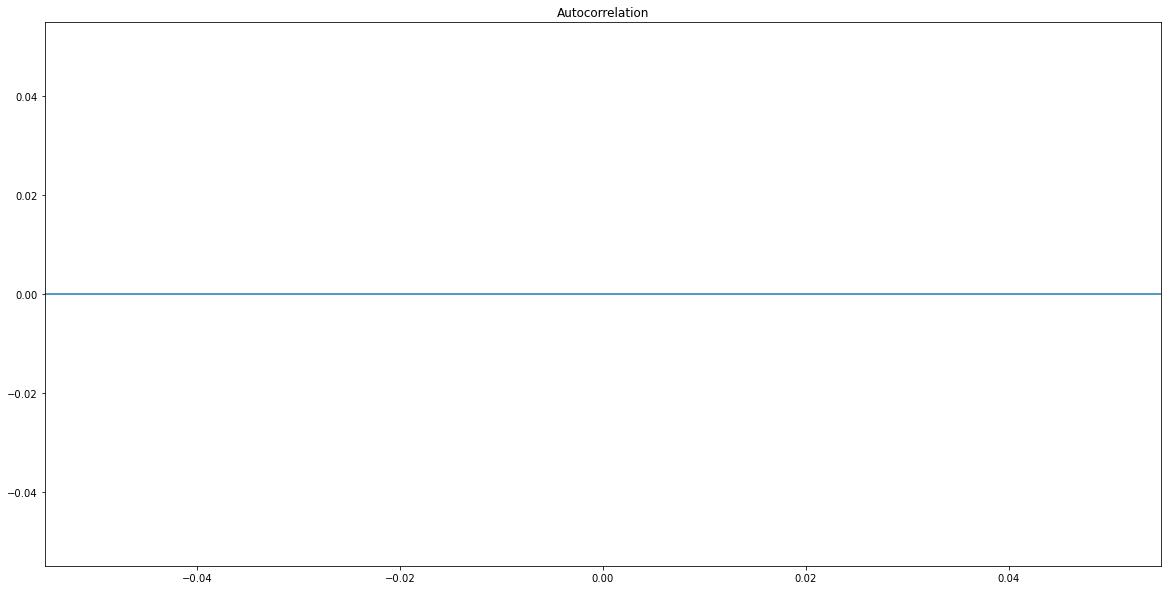

In [244]:
plot_acf(pc_snow, alpha=1)

In [245]:
# let's try to use STUMPY
import stumpy
m = 7
mp = stumpy.stump(ALTA['SNOW'], m)
mp.shape

(21803, 4)

In [246]:
#before plotting, let's find the minimum (sequences that are most like each other)
print(mp[:, 0].min())

0.0


In [247]:
# that number would make sense. Let's find the indices for that value
mp_min = np.where(mp[:,0] == 0)[0]
mp_min.shape

(12300,)

This means that the majority of the values in the matrix profile have values of 0 - they have identical patterns over a 7-day stretch, but that's likely when they don't see any snow. We care about the anamolies. How do we find those?

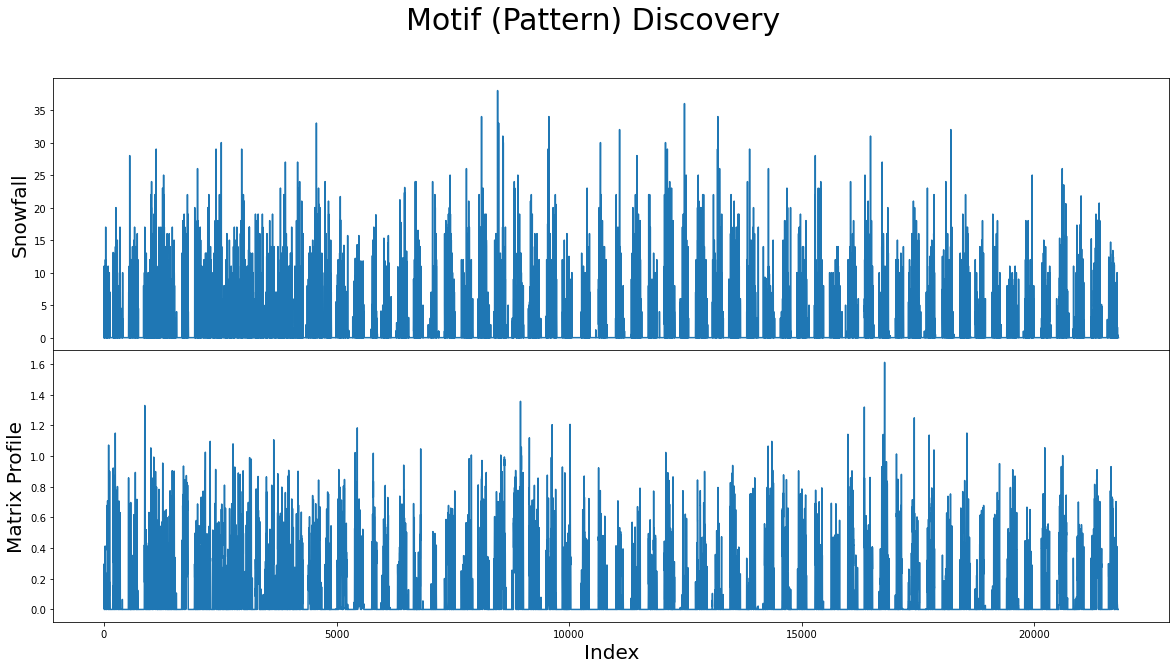

In [248]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
_ = plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(ALTA['SNOW'].values)
axs[0].set_ylabel('Snowfall', fontsize='20')
#rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)
#rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)

axs[1].set_xlabel('Index', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
#axs[1].axvline(x=643, linestyle="dashed")
#axs[1].axvline(x=8724, linestyle="dashed")
_ = axs[1].plot(mp[:, 0])

There were a lot of matrix profile 0's because there are a lot of zero values of snowfall. That's because this ALTA DF includes summer. Let's filter it so that we are just looking at 

In [249]:
win = ALTA[ALTA.MONTH.isin(['11','12','01','02','03','04'])]
win.head()

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO,SNOW7,SNOW14,SNOW30,DEN,MD
0,1944-11-21,0.00,0.0,20.0,52.0,9.0,20.0,11,21,-0.48,0.272,0.0,0.0,0.0,NaN,11-21
1,1944-11-22,0.00,0.0,19.0,48.0,19.0,29.0,11,22,-0.48,0.272,0.0,0.0,0.0,NaN,11-22
2,1944-11-23,0.00,0.0,19.0,56.0,24.0,40.0,11,23,-0.48,0.272,0.0,0.0,0.0,NaN,11-23
3,1944-11-24,0.82,6.0,25.0,52.0,14.0,16.0,11,24,-0.48,0.272,0.0,0.0,0.0,7.317073,11-24
4,1944-11-25,0.06,11.0,36.0,26.0,11.0,14.0,11,25,-0.48,0.272,0.0,0.0,0.0,NaN,11-25


In [250]:
win['SNOW7'].mean()

16.701549702906686

In [251]:
# let's look at 7-day snowfall total matrix profile
mp7 = stumpy.stump(win['SNOW7'], m)
# let's see how many patterns exactly match
mp7_min = np.where(mp7[:,0] == 0)[0]
mp7_min.shape

(606,)

That's much better. Let's plot it

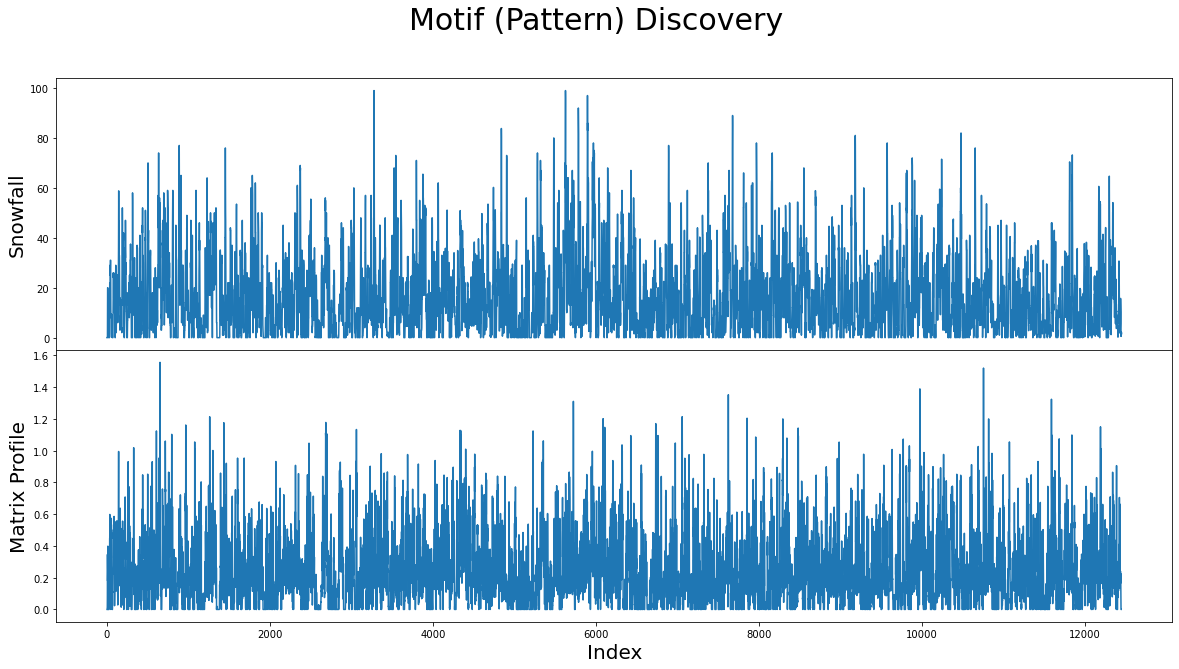

In [252]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
_ = plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(win['SNOW7'].values)
axs[0].set_ylabel('Snowfall', fontsize='20')
#rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)
#rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)

axs[1].set_xlabel('Index', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
#axs[1].axvline(x=643, linestyle="dashed")
#axs[1].axvline(x=8724, linestyle="dashed")
_ = axs[1].plot(mp7[:, 0])

In [253]:
# let's take a better look at this with FB's Prophet
from fbprophet import Prophet
# need to change the names accordingly: y - Target; ds - Datetime
SNOW = ALTA.copy()
SNOW.rename(columns={"SNOW7":"y", "DATE":"ds"}, inplace=True)

In [254]:
m_fb = Prophet(yearly_seasonality = True, daily_seasonality=False, weekly_seasonality=False)
m_fb.fit(SNOW)

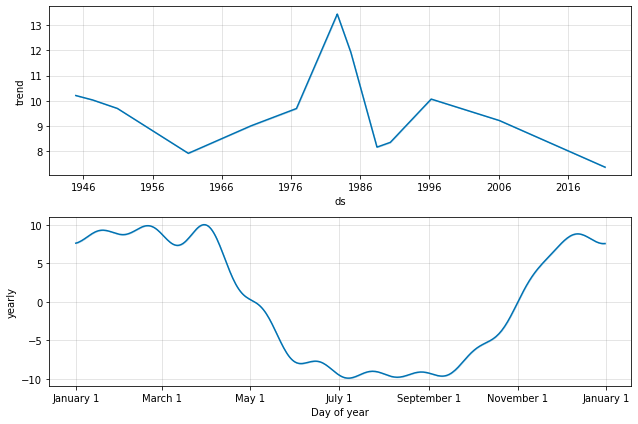

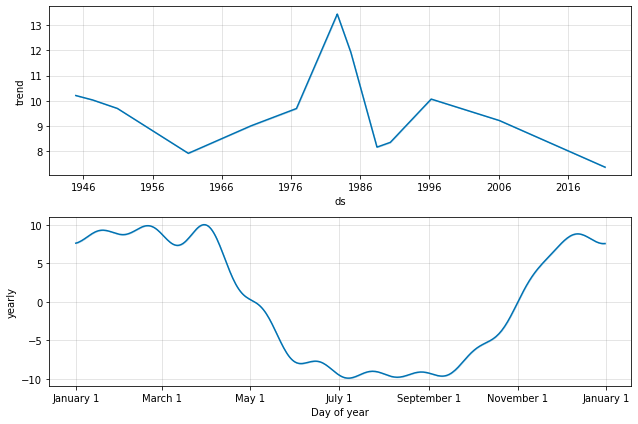

In [255]:
future = m_fb.make_future_dataframe(periods=365)
forecast = m_fb.predict(future)
m_fb.plot_components(forecast)

This looks so good. I think we'll have to build on this model more, but before I do so, there are some things that I need to do: <br>
1. Dickey-Fuller Test to see that data is stationary <br>
2. Split up each dataset for the 7-day, 14-day, and 30-day snow totals <br>



In [256]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1944-11-21,10.207034,1.364705,31.574905,10.207034,10.207034,5.655879,5.655879,5.655879,5.655879,5.655879,5.655879,0.0,0.0,0.0,15.862913
1,1944-11-22,10.206839,0.610197,31.910305,10.206839,10.206839,5.856599,5.856599,5.856599,5.856599,5.856599,5.856599,0.0,0.0,0.0,16.063437
2,1944-11-23,10.206644,1.640332,32.703257,10.206644,10.206644,6.057690,6.057690,6.057690,6.057690,6.057690,6.057690,0.0,0.0,0.0,16.264334
3,1944-11-24,10.206448,1.875571,31.058367,10.206448,10.206448,6.259574,6.259574,6.259574,6.259574,6.259574,6.259574,0.0,0.0,0.0,16.466022
4,1944-11-25,10.206253,0.917597,31.908177,10.206253,10.206253,6.462326,6.462326,6.462326,6.462326,6.462326,6.462326,0.0,0.0,0.0,16.668579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22169,2021-05-12,7.367682,-10.345946,20.519597,7.354022,7.391133,-1.538770,-1.538770,-1.538770,-1.538770,-1.538770,-1.538770,0.0,0.0,0.0,5.828912
22170,2021-05-13,7.367350,-9.172909,21.001052,7.353822,7.390883,-1.841357,-1.841357,-1.841357,-1.841357,-1.841357,-1.841357,0.0,0.0,0.0,5.525993
22171,2021-05-14,7.367019,-10.628064,21.399491,7.353340,7.390634,-2.168250,-2.168250,-2.168250,-2.168250,-2.168250,-2.168250,0.0,0.0,0.0,5.198769
22172,2021-05-15,7.366687,-9.719819,19.693371,7.352709,7.390453,-2.517051,-2.517051,-2.517051,-2.517051,-2.517051,-2.517051,0.0,0.0,0.0,4.849636


In [257]:
# snow values are good here
SNOW[SNOW.MONTH.isin(['11','12','01','02','03','04'])]['y'].mean()

16.701549702906686

In [258]:
# Subtract out time series component and then do the Dickey-Fuller test on the remaining
snow7_pred = forecast.yhat
snow7_stationary = SNOW['y'] - snow7_pred
# since the forecast contains future values, those will result in NaN. Let's remove
snow7_stat = snow7_stationary[~np.isnan(snow7_stationary)]
# let's also drop the first 7 values, since those are bogus 
snow7_st = snow7_stat[7::]
# augmented dickey-fuller test on that stuff that should be stationary(-ish)
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(snow7_st)
print('Test statistic: ', adf_result[0])

Test statistic:  -18.753177280229774


In [259]:
# snow values are good here
SNOW[SNOW.MONTH.isin(['11','12','01','02','03','04'])]['y'].mean()

16.701549702906686

Woo woo! The resulting time series is stationary or at least trend stationary. 

C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least

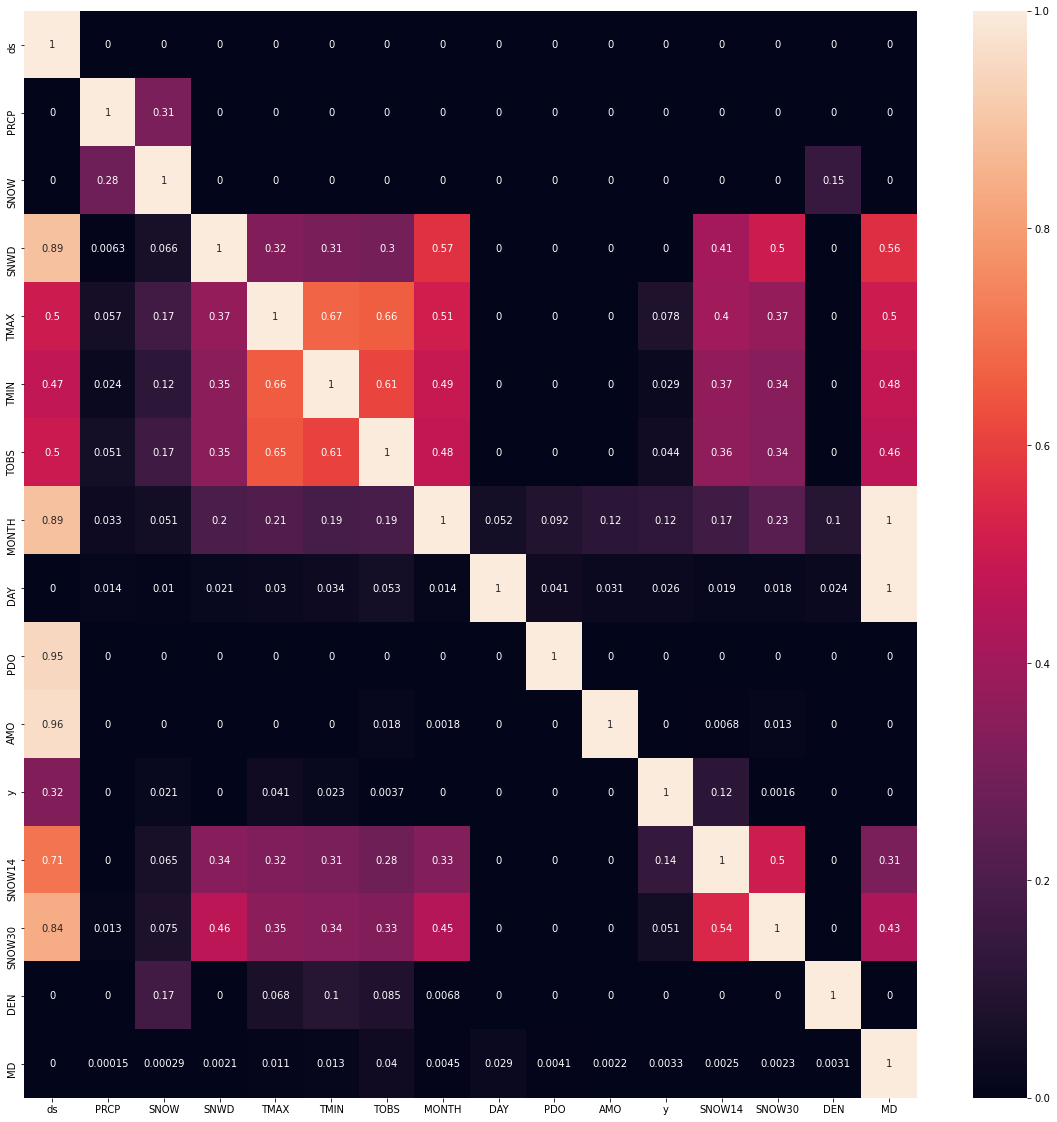

In [260]:
# let's run a predictive power score on the stationary data to see if anything new comes up in the Predictive Power Matrix
import ppscore as pps
snow7_stationary = SNOW[7::].copy()
snow7_stationary['y'] = snow7_st
snow7_st_pps = pps.matrix(snow7_stationary)
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(snow7_st_pps, annot=True, ax=ax)

That doesn't look promising when looking at the 'y' PPS. What if we just considered that same stationary DF during only the winter months.

In [261]:
# snow values are good here
SNOW[SNOW.MONTH.isin(['11','12','01','02','03','04'])]['y'].mean()

16.701549702906686

C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


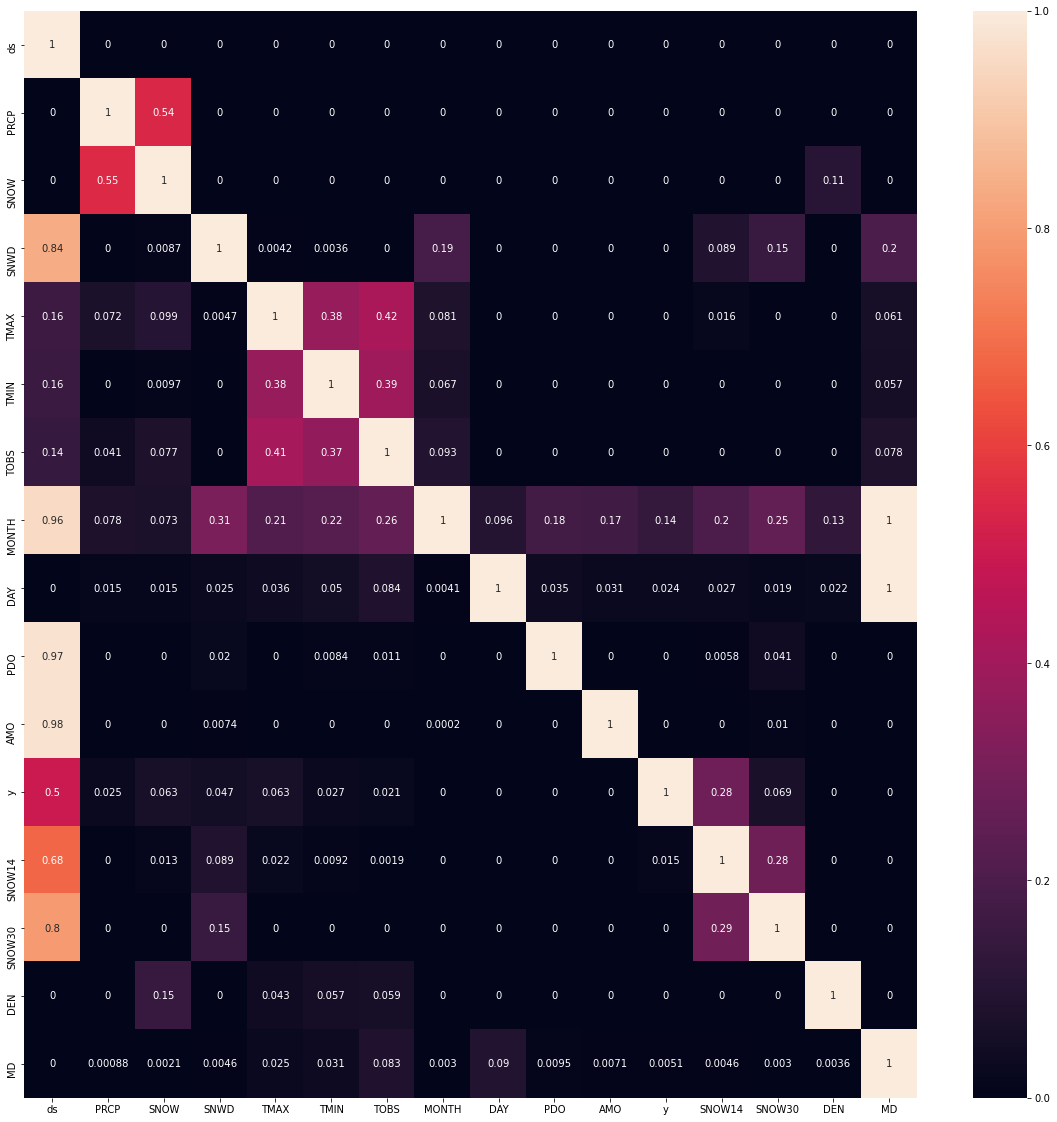

In [262]:
win_st = snow7_stationary[snow7_stationary['ds'].dt.month.isin(['12','01','02','03','04'])]
win7_st_pps = pps.matrix(win_st)
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(win7_st_pps, annot=True, ax=ax)

that's a little bit better. It suggests that 7-day snowfall total is correlated to 14-day snowfall, meaning that lag variables could be useful. 

Since FB Prophet looks to very good at fitting the time series, we don't need to separate X and Y. Y needs to be in the same Dataframe as the other X's. <br>
I will consider scaling if these models don't work well at all. <br>

In [263]:
# let's separate out the y's and then put them back once the preprocessing and scaling is done
y7 = SNOW['y']
y14 = SNOW['SNOW14']
y30 = SNOW['SNOW30']
#SNOW.drop(labels=['y', 'SNOW14', 'SNOW30'], axis=1, inplace=True)

In [264]:
SNOW[SNOW.MONTH.isin(['11','12','01','02','03','04'])]['y'].mean()

16.701549702906686

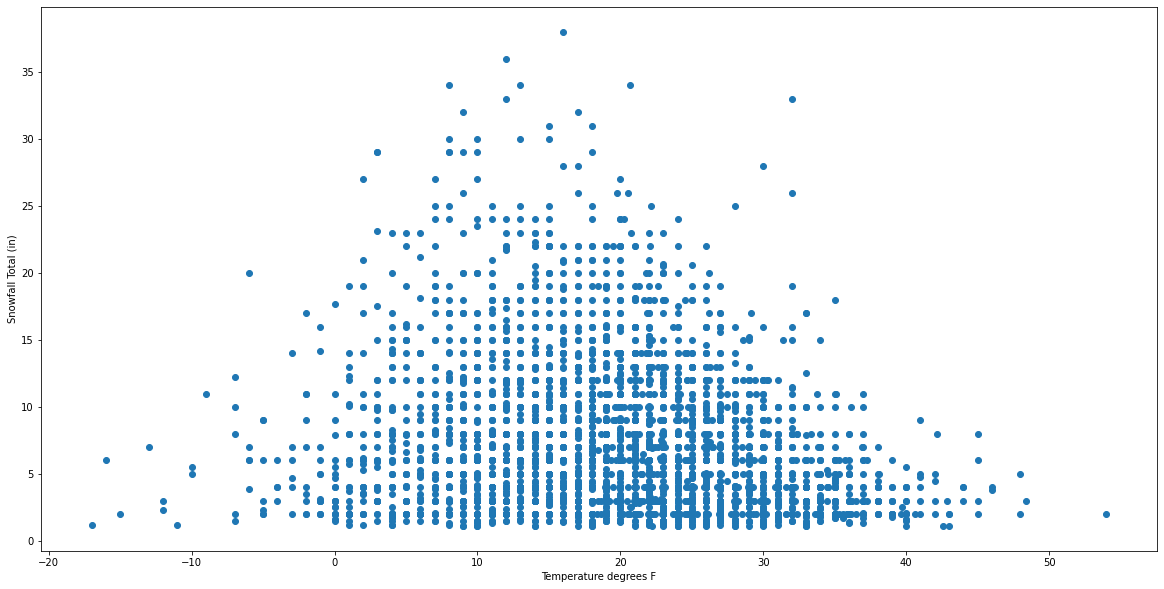

In [265]:
# let's look at snow versus temperature for any measureable snowfall
storm = SNOW[SNOW['SNOW'] > 1]
plt.scatter(storm['TOBS'], storm['SNOW'])
plt.xlabel("Temperature degrees F")
plt.ylabel('Snowfall Total (in)')
plt.show()

This looks like it would be a negative quadratic function centered around ~18 degrees <br>
Let's try the same thing for Tmin and Tmax 

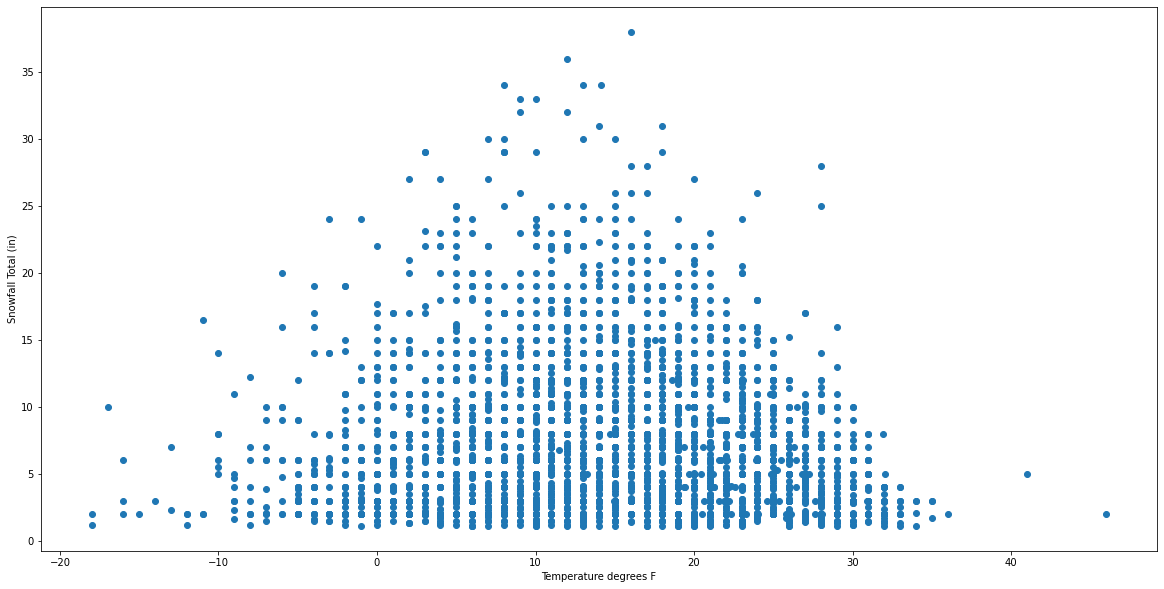

In [266]:
# let's look at snow versus temperature for any measureable snowfall
storm = SNOW[SNOW['SNOW'] > 1]
plt.scatter(storm['TMIN'], storm['SNOW'])
plt.xlabel("Temperature degrees F")
plt.ylabel('Snowfall Total (in)')
plt.show()

This looks like it is centered around ~15 degrees. That makes sense for a minimum temperature. <br>
Let's try that for Tmax

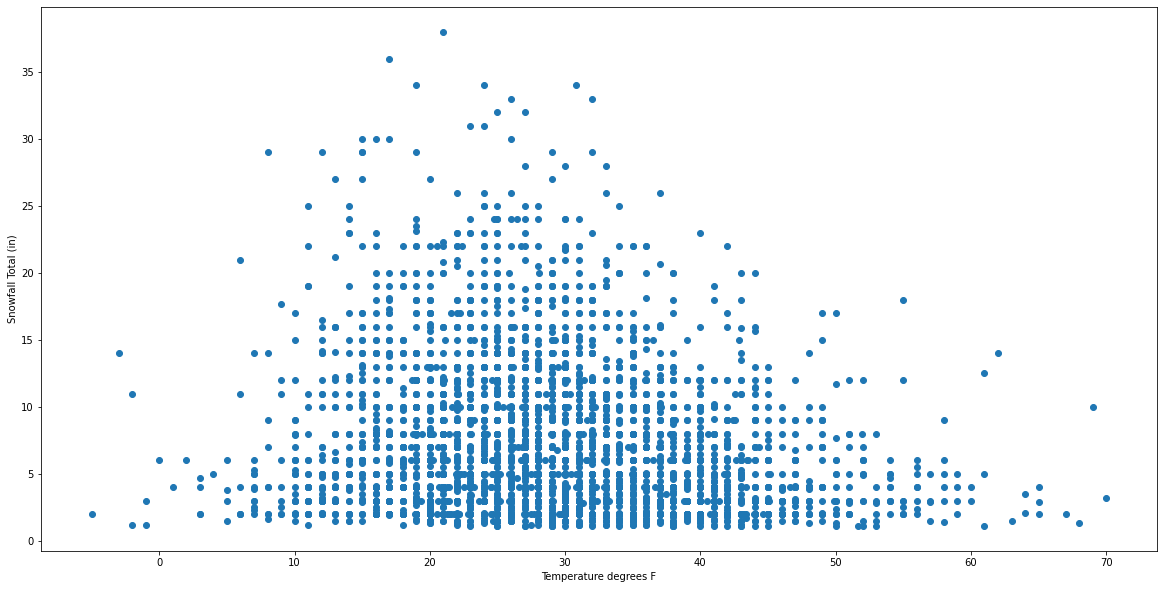

In [267]:
# let's look at snow versus temperature for any measureable snowfall
storm = SNOW[SNOW['SNOW'] > 1]
plt.scatter(storm['TMAX'], storm['SNOW'])
plt.xlabel("Temperature degrees F")
plt.ylabel('Snowfall Total (in)')
plt.show()

That peak looks around 25 degrees. <br>
Let's use these values to create a quadratic feature.

In [268]:
# let's create some more features for the regression to use that maybe useful
# Quadratic variables
SNOW['TMAX_sq'] = (25 - SNOW['TMAX'])**2
SNOW['TMIN_sq'] = (15 - SNOW['TMIN'])**2
SNOW['TOBS_sq'] = (18 - SNOW['TOBS'])**2
SNOW['AMO_sq'] = SNOW['AMO']**2
SNOW['PDO-sq'] = SNOW['PDO']**2

In [269]:
# since the snowfall sum is taken over 7, 14, and 30 days
# it would make sense to take the temperature over those time frames as well
SNOW['TMAX_7avg'] = SNOW['TMAX'].rolling(window=7).mean()
SNOW['TMIN_7avg'] = SNOW['TMIN'].rolling(window=7).mean()
SNOW['TOBS_7avg'] = SNOW['TOBS'].rolling(window=7).mean()
SNOW['TMAX_14avg'] = SNOW['TMAX'].rolling(window=14).mean()
SNOW['TMIN_14avg'] = SNOW['TMIN'].rolling(window=14).mean()
SNOW['TOBS_14avg'] = SNOW['TOBS'].rolling(window=14).mean()
SNOW['TMAX_30avg'] = SNOW['TMAX'].rolling(window=30).mean()
SNOW['TMIN_30avg'] = SNOW['TMIN'].rolling(window=30).mean()
SNOW['TOBS_30avg'] = SNOW['TOBS'].rolling(window=30).mean()

In [270]:
SNOW.head()

,ds,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,...,PDO-sq,TMAX_7avg,TMIN_7avg,TOBS_7avg,TMAX_14avg,TMIN_14avg,TOBS_14avg,TMAX_30avg,TMIN_30avg,TOBS_30avg
0,1944-11-21,0.00,0.0,20.0,52.0,9.0,20.0,11,21,-0.48,...,0.2304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1944-11-22,0.00,0.0,19.0,48.0,19.0,29.0,11,22,-0.48,...,0.2304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1944-11-23,0.00,0.0,19.0,56.0,24.0,40.0,11,23,-0.48,...,0.2304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1944-11-24,0.82,6.0,25.0,52.0,14.0,16.0,11,24,-0.48,...,0.2304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1944-11-25,0.06,11.0,36.0,26.0,11.0,14.0,11,25,-0.48,...,0.2304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [271]:
# we have a small amount of NaN's that were created at the beginning of the data set that need to be filled.
# we will fill these with the average temperature on that particular day
SNOW['TMAX_7avg'].fillna(SNOW.groupby(["MD"])["TMAX_7avg"].transform('mean'), inplace=True)
SNOW['TMIN_7avg'].fillna(SNOW.groupby(["MD"])["TMIN_7avg"].transform('mean'), inplace=True)
SNOW['TOBS_7avg'].fillna(SNOW.groupby(["MD"])["TOBS_7avg"].transform('mean'), inplace=True)
SNOW['TMAX_14avg'].fillna(SNOW.groupby(["MD"])["TMAX_14avg"].transform('mean'), inplace=True)
SNOW['TMIN_14avg'].fillna(SNOW.groupby(["MD"])["TMIN_14avg"].transform('mean'), inplace=True)
SNOW['TOBS_14avg'].fillna(SNOW.groupby(["MD"])["TOBS_14avg"].transform('mean'), inplace=True)
SNOW['TMAX_30avg'].fillna(SNOW.groupby(["MD"])["TMAX_30avg"].transform('mean'), inplace=True)
SNOW['TMIN_30avg'].fillna(SNOW.groupby(["MD"])["TMIN_30avg"].transform('mean'), inplace=True)
SNOW['TOBS_30avg'].fillna(SNOW.groupby(["MD"])["TOBS_30avg"].transform('mean'), inplace=True)

In [272]:
SNOW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21809 entries, 0 to 21808
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          21809 non-null  datetime64[ns]
 1   PRCP        21809 non-null  float64       
 2   SNOW        21809 non-null  float64       
 3   SNWD        21809 non-null  float64       
 4   TMAX        21809 non-null  float64       
 5   TMIN        21809 non-null  float64       
 6   TOBS        21809 non-null  float64       
 7   MONTH       21809 non-null  object        
 8   DAY         21809 non-null  object        
 9   PDO         21808 non-null  float64       
 10  AMO         21808 non-null  float64       
 11  y           21809 non-null  float64       
 12  SNOW14      21809 non-null  float64       
 13  SNOW30      21809 non-null  float64       
 14  DEN         2084 non-null   float64       
 15  MD          21809 non-null  object        
 16  TMAX_sq     21809 non-

That looks good and Density is about to get dropped anyway. <br>
Let's look at the Predictive Power Index for these before we export them. 

C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least

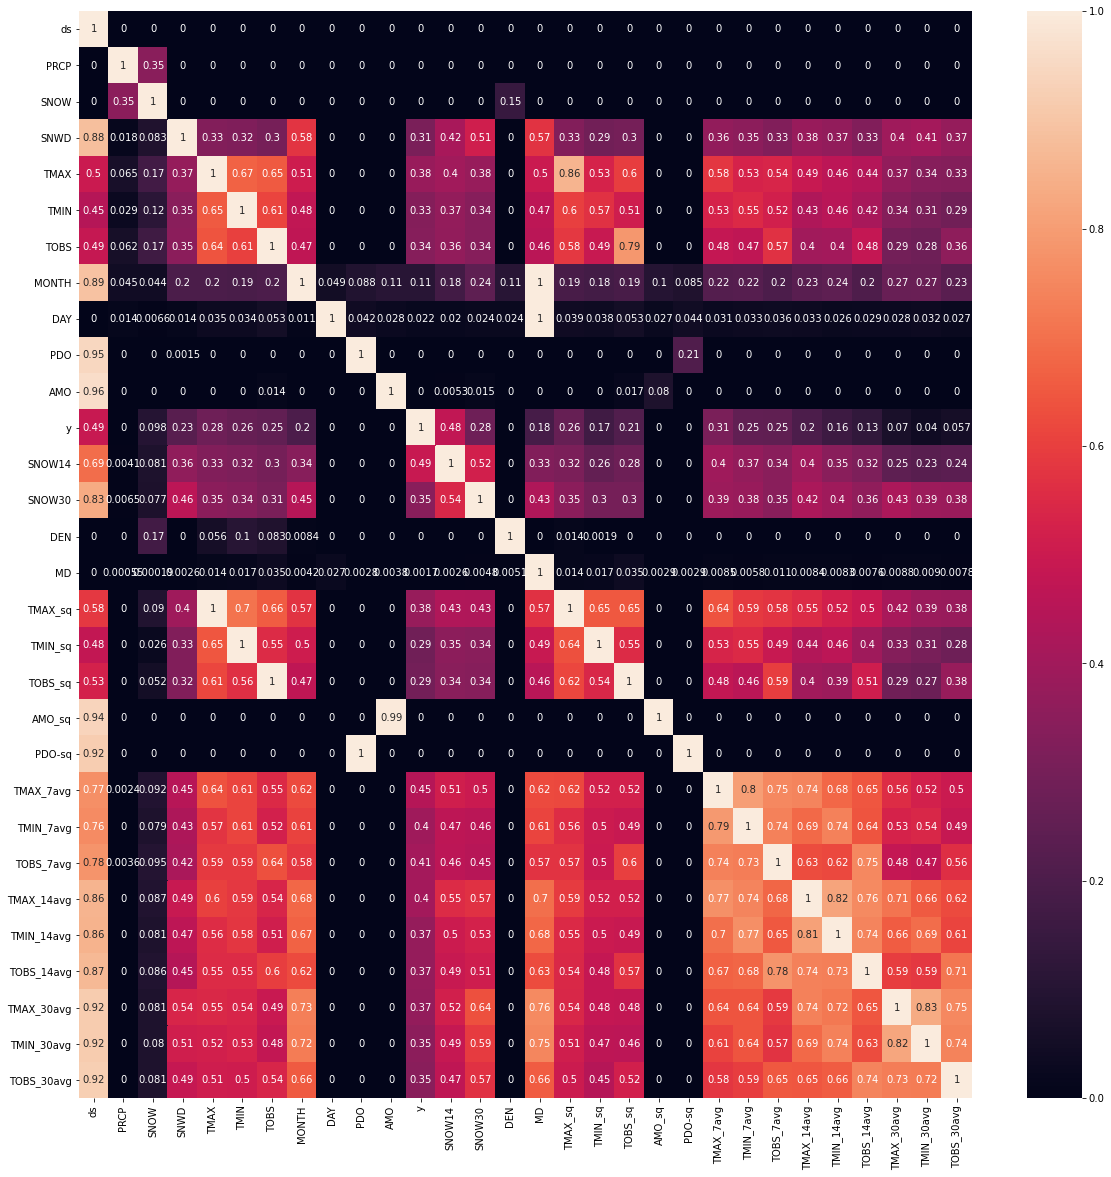

In [273]:
import ppscore as pps
snow_pps = pps.matrix(SNOW)
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(snow_pps, annot=True, ax=ax)

Let's recognize the variables that are NOT useful: DAY, PDO, AMO, DEN, AMO_sq, PDO_sq all don't seem to have an effect on snowfall when looking at this larger data set, but this includes summer. I wonder if the resutls would be different if we just cut out everything except for winter.


C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


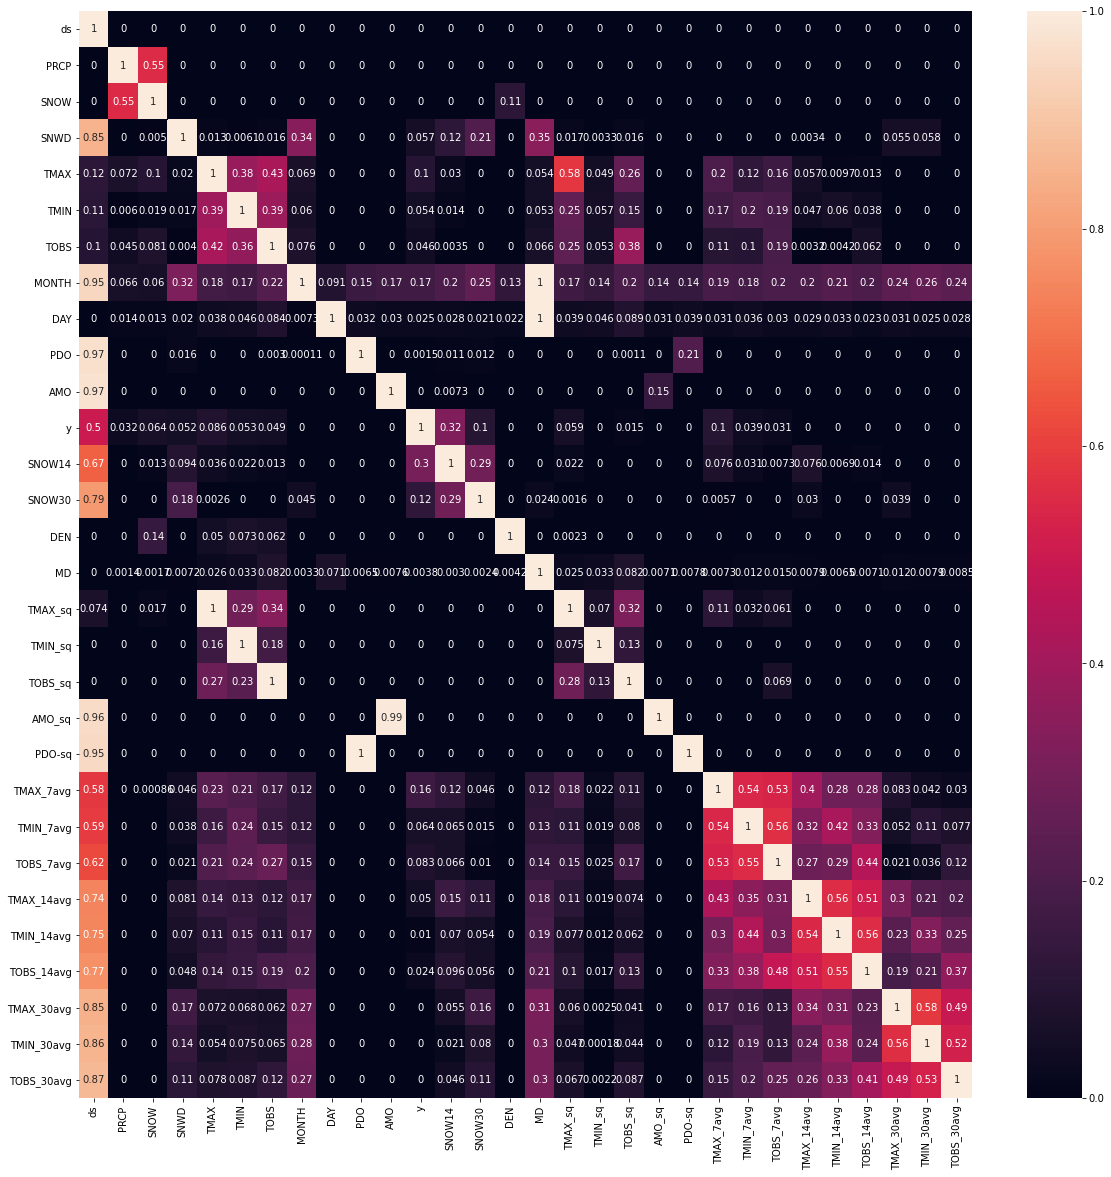

In [274]:
# only look at correlation in the winter months
win = SNOW[SNOW['ds'].dt.month.isin(['11','12','01','02','03','04'])]
win_pps = pps.matrix(win)
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(win_pps, annot=True, ax=ax)

Conclusions for each variable: <br>
For predicting 1-day snowfall, it looks like nothing is relevant (variable: SNOW) <br>
<br>
For 7-day snowfall (variable: y): <br>
TMAX_sq does look that important, but it's more important than the other squared temperatures. We may need an average over that time; this also appears true for Tmax_7avg <br>
I should probably take a 7-day average of TMAX_sq <br>
PDO and AMO don't seem to affect anything. <br>
<br>
For 14-day snowfall (variable: SNOW14): <br>
TMAX and TMAX_sq both look more important than the other temperatures. I should take a 14-day average of the TMAX_sq and I may want to change TMAX_sq equation <br>
<br>
Likewise for the 30-day snowfall (variable: SNOW30): <br>
TMAX appears more important than the other temperatures. <br>
<br>
Let's drop some variables and also take the average of the TMAX_sq over 7, 14, and 30 days. We also should add lag variables to see if those have any correlation. <br>



In [275]:
# take sq of Tmax for the 7, 14, and 30 day average
SNOW['TMAX_7avg_sq'] = SNOW['TMAX_7avg']**2
SNOW['TMAX_14avg_sq'] = SNOW['TMAX_14avg']**2
SNOW['TMAX_30avg_sq'] = SNOW['TMAX_30avg']**2

In [276]:
# take precipitation lag and possibly use a 30-day, 60, 90, and 120 sum
SNOW['PRCP_30'] = SNOW['PRCP'].shift(30).rolling(window=30).sum()
SNOW['PRCP_60'] = SNOW['PRCP'].shift(60).rolling(window=30).sum()
SNOW['PRCP_90'] = SNOW['PRCP'].shift(90).rolling(window=30).sum()
SNOW['PRCP_120'] = SNOW['PRCP'].shift(120).rolling(window=30).sum()

C:\Users\sjrek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


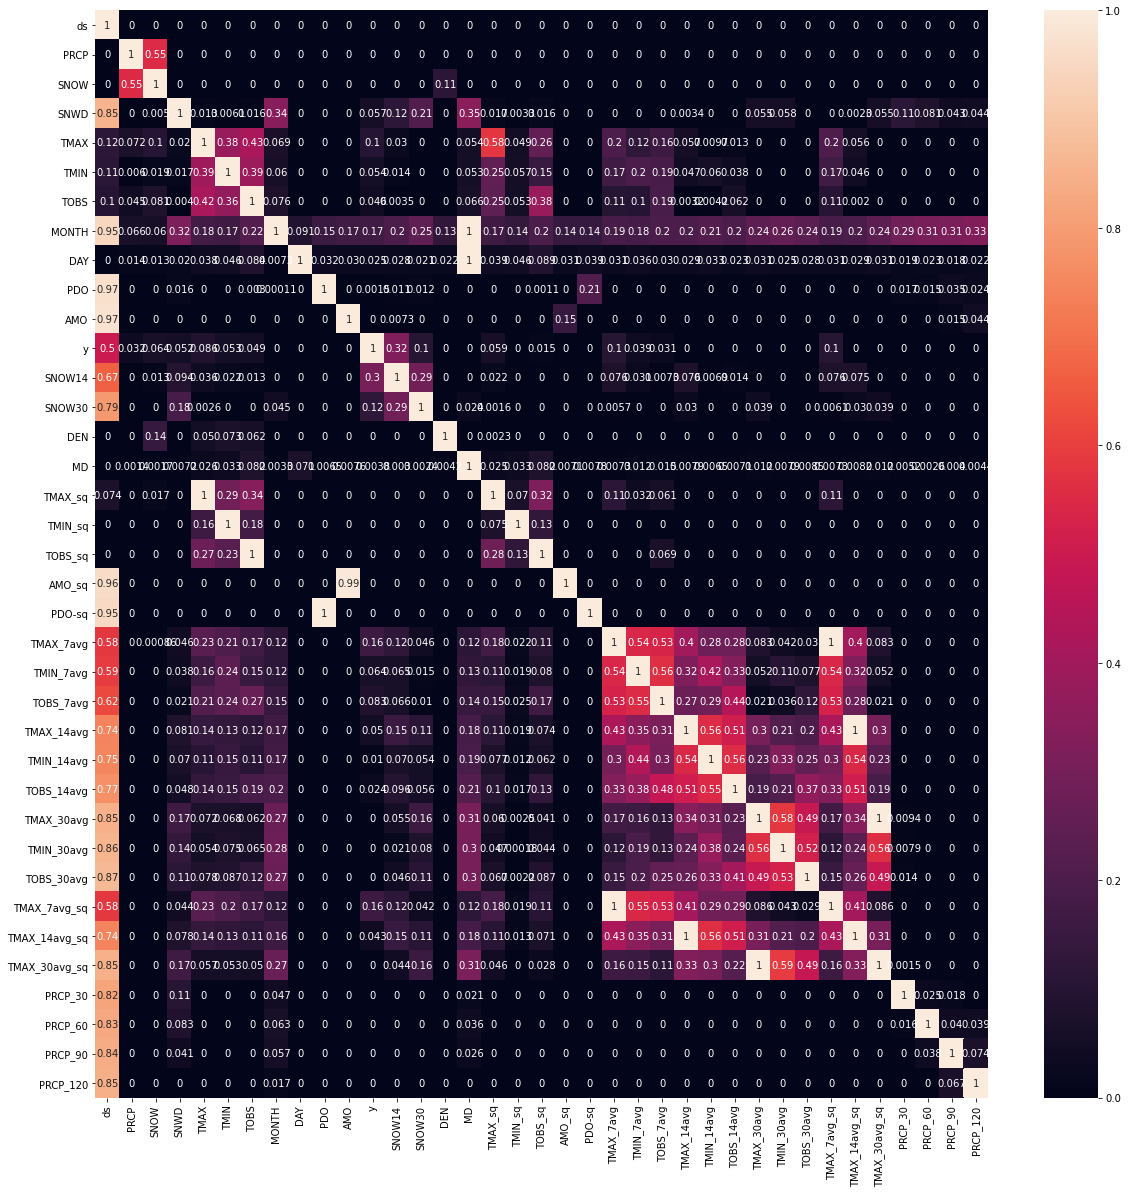

In [277]:
# let's try the PPS just one more time
win = SNOW[SNOW['ds'].dt.month.isin(['11','12','01','02','03','04'])]
win_pps = pps.matrix(win)
fig, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(win_pps, annot=True, ax=ax)

That doesn't look promising, but I will still bring them along for the modeling ride. First, I should eliminate the NaN values with fulls for those features I just created.

In [278]:
SNOW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21809 entries, 0 to 21808
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             21809 non-null  datetime64[ns]
 1   PRCP           21809 non-null  float64       
 2   SNOW           21809 non-null  float64       
 3   SNWD           21809 non-null  float64       
 4   TMAX           21809 non-null  float64       
 5   TMIN           21809 non-null  float64       
 6   TOBS           21809 non-null  float64       
 7   MONTH          21809 non-null  object        
 8   DAY            21809 non-null  object        
 9   PDO            21808 non-null  float64       
 10  AMO            21808 non-null  float64       
 11  y              21809 non-null  float64       
 12  SNOW14         21809 non-null  float64       
 13  SNOW30         21809 non-null  float64       
 14  DEN            2084 non-null   float64       
 15  MD             2180

In [279]:
win['y'].mean()

16.701549702906686

In [280]:
# those NaN values for PDO and AMO will not work in modeling. We'll drop that last row like it's hot (it's hot in May anyway)
SNOW.drop(labels=21808, inplace=True, axis=0)

In [281]:
# the precip sums that we just created need values at the beginning of the data frame. We'll use the mean for that date
SNOW['PRCP_30'].fillna(SNOW.groupby(["MD"])["PRCP_30"].transform('mean'), inplace=True)
SNOW['PRCP_60'].fillna(SNOW.groupby(["MD"])["PRCP_60"].transform('mean'), inplace=True)
SNOW['PRCP_90'].fillna(SNOW.groupby(["MD"])["PRCP_90"].transform('mean'), inplace=True)
SNOW['PRCP_120'].fillna(SNOW.groupby(["MD"])["PRCP_120"].transform('mean'), inplace=True)

In [282]:
SNOW.tail()

,ds,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,...,TMAX_30avg,TMIN_30avg,TOBS_30avg,TMAX_7avg_sq,TMAX_14avg_sq,TMAX_30avg_sq,PRCP_30,PRCP_60,PRCP_90,PRCP_120
21803,2020-05-11,0.00,0.0,38.0,60.0,40.0,58.0,05,11,-0.626667,...,46.833333,28.533333,42.233333,3040.734694,2985.841837,2193.361111,5.49,3.18,9.21,7.87
21804,2020-05-12,0.00,0.0,37.0,58.0,45.0,52.0,05,12,-0.600000,...,47.600000,29.333333,43.166667,3104.081633,3032.862245,2265.760000,5.72,3.11,9.13,6.63
21805,2020-05-13,0.01,0.0,36.0,52.0,33.0,45.0,05,13,-0.573333,...,48.533333,30.000000,44.033333,3056.510204,2954.698980,2355.484444,5.81,3.11,8.82,6.82
21806,2020-05-14,0.00,0.0,34.0,45.0,31.0,43.0,05,14,-0.546667,...,49.066667,30.800000,44.566667,2962.469388,2846.984694,2407.537778,5.79,3.13,8.82,6.50
21807,2020-05-15,0.00,0.0,32.0,47.0,34.0,45.0,05,15,-0.520000,...,49.566667,31.166667,45.066667,2900.591837,2756.250000,2456.854444,6.02,3.13,8.82,6.50


In [283]:
# since month, day, and MD are captured in the ds, we don't need those. Let's drop them.
# let's also drop DENsity since that was artificially created as a combination of the SNOW and PRCP
SNOW.drop(labels=['MONTH', 'DAY', 'MD', 'DEN'], axis=1, inplace=True)
SNOW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21808 entries, 0 to 21807
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             21808 non-null  datetime64[ns]
 1   PRCP           21808 non-null  float64       
 2   SNOW           21808 non-null  float64       
 3   SNWD           21808 non-null  float64       
 4   TMAX           21808 non-null  float64       
 5   TMIN           21808 non-null  float64       
 6   TOBS           21808 non-null  float64       
 7   PDO            21808 non-null  float64       
 8   AMO            21808 non-null  float64       
 9   y              21808 non-null  float64       
 10  SNOW14         21808 non-null  float64       
 11  SNOW30         21808 non-null  float64       
 12  TMAX_sq        21808 non-null  float64       
 13  TMIN_sq        21808 non-null  float64       
 14  TOBS_sq        21808 non-null  float64       
 15  AMO_sq         2180

In [284]:
# let's construct the X dataframe's for each y value
X7 = SNOW.loc[:,['ds','TMAX_7avg', 'TMIN_7avg', 'TOBS_7avg', 'PDO', 'AMO', 'y', 'PRCP', 'TMAX_7avg_sq', 'PRCP_30', 'PRCP_60', 'PRCP_90', 'PRCP_120', 'AMO_sq', 'PDO-sq']]
X14 = SNOW.loc[:,['ds','TMAX_14avg', 'TMIN_14avg', 'TOBS_14avg', 'PDO', 'AMO', 'SNOW14', 'PRCP', 'TMAX_14avg_sq', 'PRCP_30', 'PRCP_60', 'PRCP_90', 'PRCP_120', 'AMO_sq', 'PDO-sq']].rename(columns={"SNOW14":"y"})
X30 = SNOW.loc[:,['ds','TMAX_30avg', 'TMIN_30avg', 'TOBS_30avg', 'PDO', 'AMO', 'SNOW30', 'PRCP', 'TMAX_30avg_sq', 'PRCP_30', 'PRCP_60', 'PRCP_90', 'PRCP_120', 'AMO_sq', 'PDO-sq']].rename(columns={"SNOW30":"y"})

In [285]:
# let's see the distribution before exporting the data
X7.describe()

,TMAX_7avg,TMIN_7avg,TOBS_7avg,PDO,AMO,y,PRCP,TMAX_7avg_sq,PRCP_30,PRCP_60,PRCP_90,PRCP_120,AMO_sq,PDO-sq
count,21808.000000,21808.000000,21808.000000,21808.000000,21808.000000,2.180800e+04,21808.000000,21808.000000,2.180800e+04,2.180800e+04,2.180800e+04,2.180800e+04,21808.000000,21808.000000
mean,46.090658,27.218708,36.994362,-0.314719,0.003105,1.051094e+01,0.154559,2393.482705,4.642093e+00,4.641455e+00,4.637404e+00,4.629861e+00,0.046892,1.233719
std,16.405680,14.266430,16.972995,1.065234,0.216529,1.425854e+01,0.357703,1618.976289,3.448885e+00,3.448434e+00,3.447101e+00,3.443647e+00,0.056000,1.466696
min,4.000000,-9.285714,-4.714286,-3.170000,-0.527000,-4.440892e-14,0.000000,16.000000,1.043610e-14,1.043610e-14,1.043610e-14,1.043610e-14,0.000000,0.000000
25%,32.714286,15.950086,23.285714,-1.155541,-0.152215,-1.965095e-14,0.000000,1070.224490,2.050000e+00,2.060000e+00,2.060000e+00,2.060000e+00,0.006115,0.131699
50%,42.428571,24.624742,33.000000,-0.261801,0.010298,4.000000e+00,0.000000,1800.183673,3.900000e+00,3.900000e+00,3.900000e+00,3.890000e+00,0.024371,0.650269
75%,60.715836,39.285714,50.857143,0.454274,0.158827,1.700000e+01,0.120000,3686.412779,6.510000e+00,6.510000e+00,6.500000e+00,6.490000e+00,0.069512,1.866529
max,85.428571,68.142857,78.142857,2.550000,0.519000,9.900000e+01,5.000000,7298.040816,2.631000e+01,2.631000e+01,2.631000e+01,2.631000e+01,0.277729,10.048900


In [286]:
# let's see the distribution before exporting the data
X14.describe()

,TMAX_14avg,TMIN_14avg,TOBS_14avg,PDO,AMO,y,PRCP,TMAX_14avg_sq,PRCP_30,PRCP_60,PRCP_90,PRCP_120,AMO_sq,PDO-sq
count,21808.000000,21808.000000,21808.000000,21808.000000,21808.000000,2.180800e+04,21808.000000,21808.000000,2.180800e+04,2.180800e+04,2.180800e+04,2.180800e+04,21808.000000,21808.000000
mean,46.087134,27.217280,36.991268,-0.314719,0.003105,2.101721e+01,0.154559,2377.239397,4.642093e+00,4.641455e+00,4.637404e+00,4.629861e+00,0.046892,1.233719
std,15.913109,13.814979,16.547140,1.065234,0.216529,2.345073e+01,0.357703,1585.120018,3.448885e+00,3.448434e+00,3.447101e+00,3.443647e+00,0.056000,1.466696
min,11.214286,-4.357143,3.642857,-3.170000,-0.527000,-7.105427e-14,0.000000,125.760204,1.043610e-14,1.043610e-14,1.043610e-14,1.043610e-14,0.000000,0.000000
25%,32.857143,16.000000,23.214286,-1.155541,-0.152215,-1.265654e-14,0.000000,1079.591837,2.050000e+00,2.060000e+00,2.060000e+00,2.060000e+00,0.006115,0.131699
50%,41.762388,24.142857,32.714286,-0.261801,0.010298,1.400000e+01,0.000000,1744.097094,3.900000e+00,3.900000e+00,3.900000e+00,3.890000e+00,0.024371,0.650269
75%,60.514514,38.928571,50.642857,0.454274,0.158827,3.450000e+01,0.120000,3662.006834,6.510000e+00,6.510000e+00,6.500000e+00,6.490000e+00,0.069512,1.866529
max,82.642857,63.442857,76.142857,2.550000,0.519000,1.540000e+02,5.000000,6829.841837,2.631000e+01,2.631000e+01,2.631000e+01,2.631000e+01,0.277729,10.048900


In [287]:
# let's see the distribution before exporting the data
X30.describe()

,TMAX_30avg,TMIN_30avg,TOBS_30avg,PDO,AMO,y,PRCP,TMAX_30avg_sq,PRCP_30,PRCP_60,PRCP_90,PRCP_120,AMO_sq,PDO-sq
count,21808.000000,21808.000000,21808.000000,21808.000000,21808.000000,2.180800e+04,21808.000000,21808.000000,2.180800e+04,2.180800e+04,2.180800e+04,2.180800e+04,21808.000000,21808.000000
mean,46.080985,27.213170,36.985348,-0.314719,0.003105,4.502777e+01,0.154559,2360.580018,4.642093e+00,4.641455e+00,4.637404e+00,4.629861e+00,0.046892,1.233719
std,15.399146,13.351390,16.086632,1.065234,0.216529,4.231446e+01,0.357703,1542.375679,3.448885e+00,3.448434e+00,3.447101e+00,3.443647e+00,0.056000,1.466696
min,19.427957,-0.100000,9.478462,-3.170000,-0.527000,-2.016165e-13,0.000000,377.445513,1.043610e-14,1.043610e-14,1.043610e-14,1.043610e-14,0.000000,0.000000
25%,32.933333,15.866667,23.300087,-1.155541,-0.152215,2.500000e+00,0.000000,1084.604444,2.050000e+00,2.060000e+00,2.060000e+00,2.060000e+00,0.006115,0.131699
50%,41.233333,23.600000,32.360142,-0.261801,0.010298,3.900000e+01,0.000000,1700.187778,3.900000e+00,3.900000e+00,3.900000e+00,3.890000e+00,0.024371,0.650269
75%,60.166667,38.866667,50.446233,0.454274,0.158827,7.300000e+01,0.120000,3620.027778,6.510000e+00,6.510000e+00,6.500000e+00,6.490000e+00,0.069512,1.866529
max,79.600000,60.733333,73.966667,2.550000,0.519000,2.675000e+02,5.000000,6336.160000,2.631000e+01,2.631000e+01,2.631000e+01,2.631000e+01,0.277729,10.048900


Normally, I would want to use feature tools on the data, scale the data, and split the data. However, since it's time series data, I won't do that. When I make a model for this time, I will do each of these steps every time I split out the data - use feature tools and scale (if needed). 

In [288]:
# let's export all of this fun stuff
# let's save the DF to both pickle and CSV
X7.to_pickle("X7_snow_pp.pkl")
X7.to_csv("X7_snow_pp.csv")
X14.to_pickle("X14_snow_pp.pkl")
X14.to_csv("X14_snow_pp.csv")
X30.to_pickle("X30_snow_pp.pkl")
X30.to_csv("X30_snow_pp.csv")


See you in the next notebook to do modeling.